In [1]:
import os
print(os.getcwd())

/Users/user/Desktop/dailyreports


In [2]:
import numpy as np
import pandas as pd
import urllib
import re
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm             # these two imports as used in Boston Housing mini-project
from statsmodels.formula.api import ols
# import statsmodel.formula.spi as smf

def read_one_day(date):
    link = "http://content.caiso.com/green/renewrpt/{}_DailyRenewablesWatch.txt".format(date)
    url = urllib.request.urlopen(link)
    content = [str(word) for word in url.readlines()] # converting each word of each line to strings

    # Note these are static, so may need to be adjusted.  Looks to be the same each day though.
    # Could be possible to parse on the fly, but start simple for now
    renewable_columns = ['hour', 'geo', 'biom', 'biog', 'shydro', 'wind', 'solarPV', 'sTH']
    renewable_data = content[2:26]    
    total_columns = ['hour', 'srnwbls','nucl', 'thermal', 'imports', 'lhydro']
    total_data = content[30:]    
    
    parsed_renewable = [parse_array(row) for row in renewable_data] # calling function below w 3 Regular Expression calls
    parsed_total = [parse_array(row) for row in total_data] # same
    
    renewable = pd.DataFrame(parsed_renewable, columns=renewable_columns)
    total = pd.DataFrame(parsed_total, columns=total_columns)
    
    renewable['DATE'] = date
    total['DATE'] = date
    df= pd.merge(renewable,total,on= 'hour')  # s = pd.Series(["a", "b", "c", "a"], dtype="category")//pd.series( ,dtype= 'category') rejected
    df.hour= ['00','01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','21','22','23']
    df['DT'] = pd.to_datetime(df['DATE_y'] + ' ' + df['hour'] + ':00:00')
    df.set_index(df['DT'], inplace= True)
    df= df.drop(['DATE_x','DATE_y','DT'], axis=1)
    # df['hour']= df['hour'].astype('category', ordered=True)# categories=[2, 1]
    # FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
    return df
    
def parse_array(one_row):
    no_chars = re.sub(r"[a-zA-Z']", "", one_row) # were commas used to denote thousands (so needed to be removed)
    no_slashes = re.sub(r"\\+", ",", no_chars)
    splitted_strings = no_slashes[1:-1].split(',')
    return [int(elem) for elem in splitted_strings] # interesting syntax! return a List Comprehension!
# after parsing numbers converted back to numeric for Pandas read

In [3]:
def read_one_month(year_month):  # see datetime lectures Chapter 4
    if year_month[4:6] in ['04','06','09','11']:
        d= 31
    elif year_month[4:6] == '02':
        d=29
    else:
        d=32
    month_dates_A= [(year_month + '0' + str(i)) for i in list(range(1,10))]
    month_dates_B= [(year_month + str(i)) for i in list(range(10,d))]
    month_dates= month_dates_A + month_dates_B
    dfs= [read_one_day(date) for date in month_dates] #dfs for dataframeS
    dfc= pd.concat(dfs)   
    return dfc

# This code replaced by the version above for months of variable length
def read_one_month(year_month):
    month_dates_A= [(year_month + '0' + str(i)) for i in list(range(1,10))]
    month_dates_B= [(year_month + str(i)) for i in list(range(10,32))]
    month_dates= month_dates_A + month_dates_B
    dfs= [read_one_day(date) for date in month_dates] #dfs for dataframeS
    dfc= pd.concat(dfs)   
    return dfc


In [4]:
dfc= read_one_month('201901')
dfc.info() # 31 DAYS x 24 HOURS GIVES 744
dfc.tail()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 744 entries, 2019-01-01 00:00:00 to 2019-01-31 23:00:00
Data columns (total 13 columns):
hour       744 non-null object
geo        744 non-null int64
biom       744 non-null int64
biog       744 non-null int64
shydro     744 non-null int64
wind       744 non-null int64
solarPV    744 non-null int64
sTH        744 non-null int64
srnwbls    744 non-null int64
nucl       744 non-null int64
thermal    744 non-null int64
imports    744 non-null int64
lhydro     744 non-null int64
dtypes: int64(12), object(1)
memory usage: 81.4+ KB


,hour,geo,biom,biog,shydro,wind,solarPV,sTH,srnwbls,nucl,thermal,imports,lhydro
DT,,,,,,,,,,,,,
2019-01-31 19:00:00,19,911,344,235,366,251,0,0,2107,2261,10846,9225,2872
2019-01-31 20:00:00,20,911,347,234,400,264,0,0,2156,2262,10370,9220,2530
2019-01-31 21:00:00,21,912,358,233,397,338,0,0,2238,2261,9845,8530,2318
2019-01-31 22:00:00,22,914,369,232,307,564,0,0,2386,2261,9463,7279,2031
2019-01-31 23:00:00,23,915,370,233,303,550,0,0,2371,2263,8893,6493,1927


In [5]:
# THE ABOVE SEEMS TO WORK OK !!

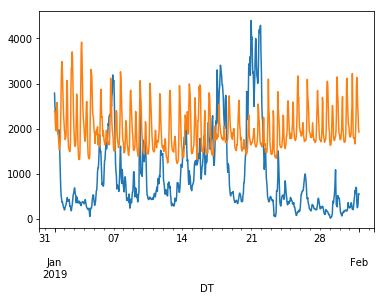

In [6]:
dfc.wind.plot()
dfc.lhydro.plot()
plt.show()


Text(0, 0.5, 'Large Hydro (MWh)')

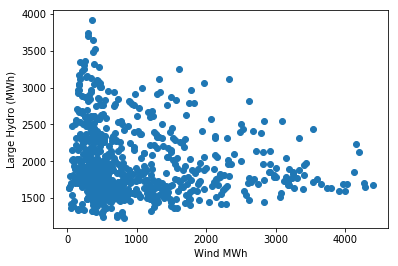

In [7]:
plt.scatter(dfc.wind, dfc.lhydro)
plt.xlabel("Wind MWh")
plt.ylabel("Large Hydro (MWh)")

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

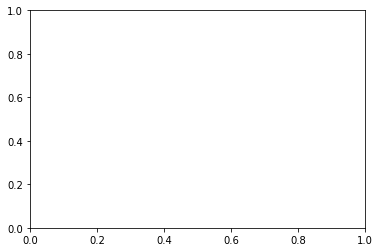

In [8]:
# dfc['hour']= dfc['hour'].astype('int') # wanted to plot as an ordered categorical variable but thrown an error
plt.boxplot(dfc['lhydro'], dfc['hour'])

# December 2018

In [ ]:
DEC= read_one_month('201812')

In [ ]:
DEC.tail()

In [ ]:
OCT= read_one_month('201810') # temp variable d is the number of days in the month, plus one.
def read_one_month(year_month):
    if year_month[4:6] in ['04','06','09','11']:
        d= 31
    elif year_month[4:6] == '02':
        d=29
    else:
        d=32
    month_dates_A= [(year_month + '0' + str(i)) for i in list(range(1,10))]
    month_dates_B= [(year_month + str(i)) for i in list(range(10,d))]
    month_dates= month_dates_A + month_dates_B
    dfs= [read_one_day(date) for date in month_dates] #dfs for dataframeS
    dfc= pd.concat(dfs)   
    return dfc

In [ ]:
twelve_months= [('2018'+ rest) for rest in ['01','02','03','04','05','06','07','08','09']] + ['201810','201811','201812']
twelve_months

In [ ]:
one_year= [read_one_month(month) for month in twelve_months]

In [10]:
six_months= [('2018'+ rest) for rest in ['01','02','03','04','05','06']]
six_months

['201801', '201802', '201803', '201804', '201805', '201806']

In [11]:
half_year= [read_one_month(month) for month in six_months]     # response ONLY after two minutes!
half_year[0] # half_year is a list of df's

,hour,geo,biom,biog,shydro,wind,solarPV,sTH,srnwbls,nucl,thermal,imports,lhydro
DT,,,,,,,,,,,,,
2018-01-01 00:00:00,00,975,304,214,299,236,0,0,2028,2260,7236,7501,2102
2018-01-01 01:00:00,01,976,304,215,301,277,0,0,2073,2259,6702,7453,2043
2018-01-01 02:00:00,02,975,304,216,301,128,0,0,1924,2260,6266,7498,2033
2018-01-01 03:00:00,03,974,303,215,301,82,0,0,1875,2261,6191,7333,1958
2018-01-01 04:00:00,04,974,305,215,301,127,0,0,1922,2261,6384,7026,2046
2018-01-01 05:00:00,05,974,306,215,299,116,0,0,1910,2262,6366,7458,2061
2018-01-01 06:00:00,06,973,316,216,468,93,0,0,2066,2262,6357,7865,2117
2018-01-01 07:00:00,07,973,319,213,510,151,814,0,2980,2262,5832,7658,1928
2018-01-01 08:00:00,08,974,322,213,513,82,3743,33,5880,2263,4664,5988,1779


In [12]:
six_months_data = pd.concat(half_year)
six_months_data.head()
six_months_data.info()
six_months_data.tail()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4344 entries, 2018-01-01 00:00:00 to 2018-06-30 23:00:00
Data columns (total 13 columns):
hour       4344 non-null object
geo        4344 non-null int64
biom       4344 non-null int64
biog       4344 non-null int64
shydro     4344 non-null int64
wind       4344 non-null int64
solarPV    4344 non-null int64
sTH        4344 non-null int64
srnwbls    4344 non-null int64
nucl       4344 non-null int64
thermal    4344 non-null int64
imports    4344 non-null int64
lhydro     4344 non-null int64
dtypes: int64(12), object(1)
memory usage: 475.1+ KB


,hour,geo,biom,biog,shydro,wind,solarPV,sTH,srnwbls,nucl,thermal,imports,lhydro
DT,,,,,,,,,,,,,
2018-06-30 19:00:00,19,986,352,221,584,3059,1083,56,6341,2263,12859,6677,4441
2018-06-30 20:00:00,20,986,369,222,584,3292,23,0,5476,2261,12946,7153,4251
2018-06-30 21:00:00,21,991,368,223,551,3559,0,0,5692,2261,11618,7781,3873
2018-06-30 22:00:00,22,992,351,226,466,4115,0,0,6150,2264,10607,7144,2970
2018-06-30 23:00:00,23,991,346,226,392,4177,0,0,6132,2267,9103,6675,2752


In [ ]:
# This version unnecesssary as the Code above does run, just with a delay of 2 minutes
# half_year= [read_one_month(month) for month in [('2018'+ rest) for rest in ['01','02','03','04','05','06']]]

In [ ]:
one_year_data= read_one_month(twelve_months[11])
# OK for 0,1,2,3,4,5,6,7,8,9,10,11 : which comprises the whole year!
#checked one month at a time!), as a precursor to the above

# Graphing six_months_data

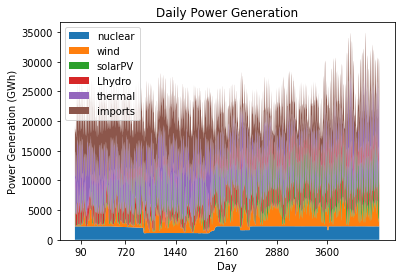

In [13]:
# six_months_data.info() # datetime index, hour as strings, rest are all type 'int'
df= six_months_data.copy()
x= range(1,4345) # number of hours
y= [df.nucl, df.wind, df.solarPV, df.lhydro, df.thermal,df.imports]
plt.stackplot(x,y,labels= ['nuclear', 'wind','solarPV','Lhydro','thermal','imports'])
plt.xticks([720,1440,90,2160,2880,3600])  # these are in Hours, not days!
plt.xlabel('Day')
plt.ylabel('Power Generation (GWh)')
plt.title('Daily Power Generation')
plt.legend(loc= 'upper left')
plt.show()                      # Completely overcrowded, so plot monthly

# Import CAISO Hourly DAM Prices

In [14]:
# files= ['DAM_Jan_2018.csv','DAM_Feb_2018.csv', 'DAM_March_2018.csv','DAM_April_2018.csv','DAM_May_2018.csv','DAM_June_2018.csv','DAM_July_2018.csv','DAM_Aug_2018.csv','DAM_Sept_2018.csv','DAM_Oct_2018.csv','DAM_Nov_2018.csv','DAM_Dec_2018.csv']
# files= ['DAM_Jan_2019.csv']

files= ['DAM_Jan_2018.csv','DAM_Feb_2018.csv', 'DAM_March_2018.csv','DAM_April_2018.csv','DAM_May_2018.csv','DAM_June_2018.csv']

frames= [ pd.read_csv(file, header= 0, usecols= [0,2,3,9,14],parse_dates= True, index_col= 'INTERVALSTARTTIME_GMT') for file in files]
df1= pd.concat(frames)
dfp= df1[df1['LMP_TYPE'] == 'LMP'] # drops the other four price components and reduces data rows by 80%
dfp['date']= pd.to_datetime(dfp['OPR_DT']) #needed for plotting after the groupby SPECIFY FORMAT!!
dfp= dfp.drop(['OPR_DT','LMP_TYPE'],axis=1)
dfp.columns= ['hour','price','day']
dfp['weekday']= dfp.day.dt.weekday_name
dfp['month']= dfp.day.dt.month #new code
dfp.index.names= ['date']
# dfp.index= dfp.index.drop_duplicates(keep='first')  
# dfp = dfp.sort_values(dfp.index) UNABLE TO SORT DUE TO DUPLICATES, BUT UNABLE TO REMOVE DUPLICATES W CODE ABOVE
dfp.info()  # WE HAVE 4343 OBSERVATIONS (AS HOURS), but the scraped data has 4344 hours: MAKE SURE NOT OFF BY AN HOUR!!
dfp.head()
dfp.tail()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4343 entries, 2018-01-01 23:00:00 to 2018-06-30 12:00:00
Data columns (total 5 columns):
hour       4343 non-null int64
price      4343 non-null float64
day        4343 non-null datetime64[ns]
weekday    4343 non-null object
month      4343 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 203.6+ KB


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,hour,price,day,weekday,month
date,,,,,
2018-06-30 20:00:00,14,30.77381,2018-06-30,Saturday,6
2018-06-30 13:00:00,7,26.89662,2018-06-30,Saturday,6
2018-07-01 03:00:00,21,50.77052,2018-06-30,Saturday,6
2018-06-30 18:00:00,12,25.32498,2018-06-30,Saturday,6
2018-06-30 12:00:00,6,36.75014,2018-06-30,Saturday,6


In [15]:
# one way to make the hours line up should be to merge the two df's (df & dfp) on the datetime index

In [16]:
dfc= pd.merge(df,dfp, how= 'inner', left_on= df.index, right_on= dfp.index)

In [17]:
dfc.head() 
# note that for CAISO prices, the dateteime is UK time, but for the scraped data the hour was imputed (so 7 hour delta)

,key_0,hour_x,geo,biom,biog,shydro,wind,solarPV,sTH,srnwbls,nucl,thermal,imports,lhydro,hour_y,price,day,weekday,month
0,2018-01-01 08:00:00,08,974,322,213,513,82,3743,33,5880,2263,4664,5988,1779,1,36.45428,2018-01-01,Monday,1
1,2018-01-01 09:00:00,09,972,321,213,338,22,5851,197,7914,2263,4544,4000,1573,2,34.76417,2018-01-01,Monday,1
2,2018-01-01 10:00:00,10,970,319,213,305,16,6395,277,8495,2263,4492,3274,1601,3,32.85036,2018-01-01,Monday,1
3,2018-01-01 11:00:00,11,967,345,214,306,41,6418,232,8523,2263,4487,3373,1547,4,31.64637,2018-01-01,Monday,1
4,2018-01-01 12:00:00,12,966,366,214,307,71,6573,202,8699,2261,4395,3280,1597,5,31.80000,2018-01-01,Monday,1


In [18]:
dfc['load']= dfc['srnwbls'] + dfc['nucl'] + dfc['thermal'] + dfc['imports'] + dfc['lhydro']
dfc= dfc.drop(columns= dfc[['hour_x','day']], axis=1)
dfc.index.names= ['date']
dfc= dfc.rename(columns= {'hour_y': 'hour'})
dfc['hour']= dfc['hour'].astype('category')
dfc['weekday']= dfc['weekday'].astype('category')
dfc['month']= dfc['month'].astype('category')
dfc['hour']= dfc['hour'].astype('str')
dfc.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4336 entries, 0 to 4335
Data columns (total 18 columns):
key_0      4336 non-null datetime64[ns]
geo        4336 non-null int64
biom       4336 non-null int64
biog       4336 non-null int64
shydro     4336 non-null int64
wind       4336 non-null int64
solarPV    4336 non-null int64
sTH        4336 non-null int64
srnwbls    4336 non-null int64
nucl       4336 non-null int64
thermal    4336 non-null int64
imports    4336 non-null int64
lhydro     4336 non-null int64
hour       4336 non-null object
price      4336 non-null float64
weekday    4336 non-null category
month      4336 non-null category
load       4336 non-null int64
dtypes: category(2), datetime64[ns](1), float64(1), int64(13), object(1)
memory usage: 584.9+ KB


In [19]:
# need to add dummies and carve out the night hours
dfc.head()
dfc.tail(10)
dfc.hour[0:30] # Hmm all 24 hours do appear and in order
dfc.hour[240:270] # also OK here

date
240     1
241     2
242     3
243     4
244     5
245     6
246     7
247     8
248     9
249    10
250    11
251    12
252    13
253    14
254    15
255    16
256    17
257    18
258    19
259    20
260    21
261    22
262    23
263    24
264     1
265     2
266     3
267     4
268     5
269     6
Name: hour, dtype: object

In [ ]:
df_wD= pd.get_dummies(dfc, drop_first= True)  # columns= [dfc.hour, dfc.weekday, dfc.month]

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
# import statsmodels.formula.api as smf
m= ols(formula= 'price ~ load + wind + solarPV + nucl + thermal + imports + lhydro + hour + weekday + month', data= dfc).fit()

In [ ]:
# .fit() already above

In [ ]:
print(m.summary())

In [ ]:
# Commentary
Allvariables except nuclear have statistically significant t-values.
However, some have a positive effect on prices rather than a negative one (such as wind and solarPV).
These surprises may be due to multicollinearity
For example, load has a negative coefficient although common sense would suggest the opposite.

In [ ]:
# So we drop nuclear, and also 'load' to hopefully reduce multicollinearity
# We see that the signs of the 'wind' & 'solarPV' variables have now switched, and make sense
# With an adjusted R-squared of 71%, this is a credible starting point for predicting all 24 hours of the day
m2= ols(formula= 'price ~ wind + solarPV +  thermal + imports + lhydro + hour + weekday + month', data= dfc).fit()

In [ ]:
print(m2.summary())

In [ ]:
dfc['hour'].isin(['1','2','3','4','5','6','23','24'])[0:30] # OK
sum(dfc['hour'].isin(['1','2','3','4','5','6','23','24'])[0:24]) # also OK

In [20]:
# Now we focus the model exclusively on the off-peak hours of interest
dfw= dfc[dfc['hour'].isin(['1','2','3','4','5','6','23','24'])]

In [21]:
dfw.head(10) # now OK 

,key_0,geo,biom,biog,shydro,wind,solarPV,sTH,srnwbls,nucl,thermal,imports,lhydro,hour,price,weekday,month,load
date,,,,,,,,,,,,,,,,,,
0,2018-01-01 08:00:00,974,322,213,513,82,3743,33,5880,2263,4664,5988,1779,1,36.45428,Monday,1,20574
1,2018-01-01 09:00:00,972,321,213,338,22,5851,197,7914,2263,4544,4000,1573,2,34.76417,Monday,1,20294
2,2018-01-01 10:00:00,970,319,213,305,16,6395,277,8495,2263,4492,3274,1601,3,32.85036,Monday,1,20125
3,2018-01-01 11:00:00,967,345,214,306,41,6418,232,8523,2263,4487,3373,1547,4,31.64637,Monday,1,20193
4,2018-01-01 12:00:00,966,366,214,307,71,6573,202,8699,2261,4395,3280,1597,5,31.80000,Monday,1,20232
5,2018-01-01 13:00:00,965,367,215,309,106,6098,274,8334,2260,4562,3698,1646,6,33.24404,Monday,1,20500
22,2018-01-02 06:00:00,967,364,213,361,75,0,0,1980,2263,7687,8562,2453,23,37.50306,Monday,1,22945
23,2018-01-02 07:00:00,965,367,213,362,90,496,0,2493,2262,8150,8652,2665,24,34.87104,Monday,1,24222
24,2018-01-02 08:00:00,967,367,210,362,107,1977,0,3990,2262,8492,7584,2428,1,35.25316,Tuesday,1,24756


In [22]:
# recreate dummies for dfw ('wee hours')
dfw_wD= pd.get_dummies(dfw, drop_first= True)  # columns= [dfw.hour, dfw.weekday, dfw.month]

In [23]:
mw1= ols(formula= 'price ~ load + wind + solarPV + nucl + thermal + imports + lhydro + hour + weekday + month', data= dfc).fit()

In [24]:
print(mw1.summary()) # Hmm very strange: we have MORE THAN 24 HOURS WHEN WE SHOULD HAVE JUST seven!!!
# SO THIS IS A NONSENSE MODEL !!

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     291.8
Date:                Mon, 18 Feb 2019   Prob (F-statistic):               0.00
Time:                        12:52:42   Log-Likelihood:                -14606.
No. Observations:                4336   AIC:                         2.930e+04
Df Residuals:                    4294   BIC:                         2.956e+04
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               72.6272 

# Various tests below on scraping different months and combinations of months.

In [ ]:
one_year[0].head()# OK

In [ ]:
OCT.head()

In [ ]:
NOV= read_one_month('201811')

In [ ]:
NOV.tail()

In [ ]:
JAN= read_one_month('201901')
JAN.head()

In [ ]:
type(JAN)

In [ ]:
four_months= pd.concat(OCT, NOV, DEC, JAN) 
#TypeError: first argument must be an iterable of pandas objects, you passed an object of type "DataFrame"
four_months.shape

In [ ]:
dfc= pd.concat(dfs)        # dfc for dataframes concatenated
dfc.shape # 744 hours, 13

In [ ]:
dfc.tail()

In [ ]:
df.info()
df.head(3)

In [ ]:
df.DD= pd.to_datetime()

In [ ]:
import pandas as pd  #Hmm, NOT tab-separated as blank columns inserted to accommodate long names!!

def text_to_df(file):

    df1= pd.read_csv(file, sep= '\s+',skiprows = 2, header= None, nrows= 24)
    df1.columns= ['hour','geo','biom','biog','shydro','wind','solar','solth']
    df2= pd.read_csv(file,sep= '\s+',skiprows = 30, header= None, nrows= 24)
    df2.columns= ['hour','SRnwbls','nucl','thermal','imports','lhydro']
    df2['load']= df2.hour + df2.SRnwbls + df2.nucl + df2.thermal + df2.imports + df2.lhydro
    df2['netload'] = df2.load - df2.SRnwbls
    df= pd.merge(df1,df2,on= 'hour')
    return df


In [ ]:
df= text_to_df('20190114_DailyRenewablesWatch.txt')
print(df.head(2))


In [ ]:
# THE requests package is much better than antiquated urllib (from DS)
# better to use that!
import requests
url= 'http://content.caiso.com/green/renewrpt/20190114_DailyRenewablesWatch.txt'
r= requests.get(url)# where r is the "Response"
jan14= r.text # is this necessary as we already have a .txt file (not HTML)
#save file w 

jan14file= open('jan14.txt', 'wb') # where wb is write binary: this saves the file (?) 

In [ ]:
# So the code runs on the downloaded file, but NOT on the API call using the requests.get() approach

In [ ]:
df_caiso_jan14= text_to_df(jan14)#does not exist!!
# df_caiso_jan14= text_to_df(jan14file) # UnsupportedOperation: read
df_caiso_jan14= text_to_df(r) # Error: Invalid file path or buffer object type: <class 'requests.models.Response'>
# DWW TRY STACK OVERFLOW FOR REFERENCES: ALSO LENOVO

In [ ]:
# we can just keep repeating with multiple df's to see them all on the same plot
import matplotlib.pyplot as plt
plt.xlabel('Hour of the Day')
plt.ylabel('Net Load (in GW)')
plt.title('The Characteristic California Solar-Driven Duck Curve: Hourly Net Load')

plt.plot(df['hour'], df['netload'])# need to convert to Numpy array first?, eg via npm= df.values: apparently NOT
plt.show()


In [ ]:
# Do we have the urllib library in the Anaconda distribution? It seems so, as no error thrown
from urllib.request import urlretrieve
url= 'http://www.caiso.com/market/Pages/ReportsBulletins/RenewablesReporting.aspx/20190114_DailyRenewablesWatch.txt'
#NB the other daily file with all the charts is not a txt file, so will not be found!!
urlretrieve( url, 'report20190114.txt')


In [ ]:
file= 'report20190114.txt'

In [ ]:
print(file)#Hmmm: check Hugo tutorial and printing the file, so we can understand how to read it!!!

In [ ]:
text_to_df('report20190114.txt') # Error tokenizing data. C error: Expected 5 fields in line 6, saw 28
# Hmm: confusing. why line 6? 28 columns seems too large vs. the 8 columns in df1 !?

In [ ]:
# Now try it for january 12th, with automatic download from the CAISO website (RE-TYPE inverted commas if pasted!!)
url2='http://www.caiso.com/market/Pages/ReportsBulletins/RenewablesReporting.aspx/20190112_DailyRenewablesWatch.txt'

In [ ]:
# paste from above then modify
url2= 'http://www.caiso.com/market/Pages/ReportsBulletins/RenewablesReporting.aspx/20190112_DailyRenewablesWatch.txt'

In [ ]:
urlretrieve( url2, 'report20190112.txt') # naming the locally downloaded file for the January 12th text file
# error message went away after retyping the pasted commas!!

In [ ]:
text_to_df('report20190112.txt') # running the function on the January 12th file
# Error tokenizing data. C error: Expected 5 fields in line 6, saw 28

In [ ]:
#Whoops: first we must correctly name the long file to download from CAISO
caisonames= [’http://www.caiso.com/market/Pages/ReportsBulletins/RenewablesReporting.aspx/'+ date + 
              /'_DailyRenewablesWatch.txt’ for date in dates] 

In [ ]:
dates= [d.strftime('%Y%m%d') for d in pd.date_range('20181201','20181231')] #try this for month of December to start
dates[0:2]

In [ ]:
filenames= []
for date in dates:
    filenames.append('report'+ date + '.text')
filenames[0:2]

In [ ]:
reportnames= ['report'+ date + '.text' for date in dates] # more succinctly using a list comprehension
reportnames[0:3]

In [ ]:
dfs= []
for report in reportnames:
    frames.append(text_to_df(report))
combined= pd.concat(dfs)
combined.shape
combined.head()
    

In [ ]:
combined.tail()

# OLD CODE LISTED BELOW FOR POSSIBLE RECYCLING: IGNORE!

In [ ]:
df_Mar= pd.read_csv('March_2018.csv', header= 0, usecols= [0,2,3,8,9,13,14],parse_dates= True, index_col= 'INTERVALSTARTTIME_GMT')

In [ ]:
df_Apr= pd.read_csv('April_2018.csv', header= 0, usecols= [0,2,3,8,9,13,14],parse_dates= True, index_col= 'INTERVALSTARTTIME_GMT')

In [ ]:
df_May= pd.read_csv('May_2018.csv', header= 0, usecols= [0,2,3,8,9,13,14],parse_dates= True, index_col= 'INTERVALSTARTTIME_GMT')

In [ ]:
df_Jun= pd.read_csv('June_2018.csv', header= 0, usecols= [0,2,3,8,9,13,14],parse_dates= True, index_col= 'INTERVALSTARTTIME_GMT')

In [ ]:
df_Jul= pd.read_csv('July_2018.csv', header= 0, usecols= [0,2,3,8,9,13,14],parse_dates= True, index_col= 'INTERVALSTARTTIME_GMT')


In [ ]:
df_Aug= pd.read_csv('August_2018.csv', header= 0, usecols= [0,2,3,8,9,13,14],parse_dates= True, index_col= 'INTERVALSTARTTIME_GMT')


In [ ]:
df_Sep= pd.read_csv('September_2018.csv', header= 0, usecols= [0,2,3,8,9,13,14],parse_dates= True, index_col= 'INTERVALSTARTTIME_GMT')

In [ ]:
df_Oct= pd.read_csv('October_2018.csv', header= 0, usecols= [0,2,3,8,9,13,14],parse_dates= True, index_col= 'INTERVALSTARTTIME_GMT')


In [ ]:
df_Nov= pd.read_csv('November_2018.csv', header= 0, usecols= [0,2,3,8,9,13,14],parse_dates= True, index_col= 'INTERVALSTARTTIME_GMT')

In [ ]:
frames= [df_Jan,df_Feb,df_Mar, df_Apr, df_May, df_Jun, df_Jul,df_Aug, df_Sep, df_Oct, df_Nov]
df1= pd.concat(frames)

In [ ]:
dfp= df1[df1['LMP_TYPE'] == 'LMP'] # drops the other four price components and reduces data rows by 80%

In [ ]:
dfp['date']= pd.to_datetime(dfp['OPR_DT']) #needed for plotting after the groupby

In [ ]:
dfp.info() # as desired, the date is now the DateTime object (perfect for time series plotting)

In [ ]:
dfp= dfp.drop(['OPR_DT','LMP_TYPE','XML_DATA_ITEM'],axis=1)
dfp.columns= ['hour','price','interval','day']
dfp['weekday']= dfp.day.dt.weekday_name
dfp.index.names= ['date']

dfp.head() # 

In [ ]:
dfp.info()

In [ ]:
# import matplotlib.pyplot as plt # shocking grid instability due to price peaks 
dfp['price'].plot()
# plt.show()

In [ ]:
Feb= dfp.loc['2018-02-01':'2018-02-28'] # if a peak of $1000/MWh occurs only 1%, it still adds $10/MWh to the mean!!!*****
Feb['price'].plot()
# So what is causing the spikes!! $10/MWh versus average of 25:mostly only for 3 months Feb, March, April (but 1% is for the YEAR)
# Easy to quantify frequency by month (could it be unexpected drops in Wind not reflected in Day-Ahead-Market ??)
# while the negative prices are more frequent at 3%, the value is maybe $20/MWh so contribution to the mean is only 
# Review "State of the Market" report by Potomac (ask them this!!)

In [ ]:
Mar= dfp.loc['2018-03-01':'2018-03-31'] # so a peak of $140/MWh is 14 cents
Feb['price'].plot()
        

In [ ]:
April= dfp.loc['2018-04-01':'2018-04-30'] # so a peak of $140/MWh is 14 cents
Feb['price'].plot()

In [ ]:
May= dfp.loc['2018-05-01':'2018-05-31'] # so a peak of $140/MWh is 14 cents
May['price'].plot()

In [ ]:
June= dfp.loc['2018-06-01':'2018-06-30'] # so a peak of $140/MWh is 14 cents
June['price'].plot()

In [ ]:
dfp.price.plot(kind='hist', bins=20) # the outliers at 1000 (50x the normal price) spoil the display


In [ ]:
dfp.boxplot(column= 'price', by= 'hour')


In [ ]:
dfp.columns
dfp.shape

In [ ]:
spikep= dfp[dfp.price > 100]  # so we have 1.2% frequency of spike prices, although optically they dominate the plots!
spikep.shape

In [ ]:
normalp= dfp[(dfp.price < 100) & (dfp.price > 0)] # 
normalp.shape

In [ ]:
negativep= dfp[(dfp.price < 0) & (dfp.price > -30)] # so almost 3% of the time we have a negative price or zero
negativep.shape   # and just four times we have prices more negative than 50

In [ ]:
normalp.boxplot(column= 'price', by= 'hour')  # below uses showfliers=False to exclude the outliers being displayed


In [ ]:
normalp.boxplot(column= 'price', by= 'hour',showfliers=False)  # showfliers=False


In [ ]:
g= normalp.groupby('hour')
g.count()

# This seems to be saying that the three hours in November with the most frequent low prices are from 10am to 3pm
# But these 172 five-minute intervals average only 29 minutes a day of prices below $20/MWh
# Level 1 charger is normally 2 hours of charging: MAY NEED TO INCREASE THRESHOLD TO 3 CENTS/$30/MWh
# BIG QUESTION IS WHETHER THE DIFFERENCE FOR PEAK EVENING PRICES EXCEEDS 25 CENTS/KWH, OF $45/MWh (see p.17 of "Charging Smart")
# Counts can be compared to 30 days x 12 Intervals = 360 Intervals/month

In [ ]:
normalp.groupby('hour').mean()
# The lowest average prices are from 9am to 4pm, which is when Solar is strongest.

In [ ]:
spikep.price.plot(kind='hist', bins=30)

In [ ]:
normalp.price.plot(kind='hist', bins=30)  # No showfliers= False !!

In [ ]:
negativep.price.plot(kind='hist', bins=30) # excludes two outliers below -50 and an additional two below -30

WHAT IS THE QUESTION: NEED TO LIMIT HOURS TO PGE NIGHT RANGE AND COMPARE 24 INTERVALS VS 12! COMPARE PRICE DELTA

In [ ]:
normalp.price.plot(kind='hist', bins=30, cumulative= True)
# Two hours per day average for a Level One EV charger is 24 intervals x 30 days = 720: THRESHOLD must be increased!!!
# Add a horizontal red line at 720 !!
# Define a function that computes the average price (eg still below 2 cents?)

In [ ]:
# this function returns PG&E's designation of Peak (P), Off-Peak (OP), or Standard (S) EV pricing according to the hour of day
def peak(hour): 
    if hour in [24,1,2,3,4,5,6,7]:
        return 'OP'
    elif hour in [15,16,17,18,19,20,21,22]:
        return 'P'
    else:
        return 'S'
    
    

COMPREHENSIVE APPROACH TO PG&E PUBLISHED SCHEDULE
if date is a public holiday (saved as a list for 2018) OR day is weekend (Saturday/Sunday) then Peak is 3-7pm (rest Off Peak)
if day is a weekday (and not a holiday) then:
Peak is 2-9pm (hours 14 to 21)...list(range(14,22)
Partial Peak is 7am to 2pm and 9-11pm: hours 7-14 & 21-23: hour in list(range(7,15)) + list(range(21,24))
Otherwise (ELSE) 'OP' which is Off-Peak

In [ ]:
# need to enter dates as strings and make the dates datetime objects with  .to_datetime() method in pandas
holidays = ['2018-01-01','2018-01-15','2018-02-19','2018-05-28','2018-07-04','2018-09-03','2018-12-25'] #list of public holidays
holidays= pd.to_datetime(holidays) 
holidays # this works OK it seems so the Boolean should match

In [ ]:
# indentation is likely a problem as I mixed tabs and spaces!! Paste this into Spyder to debug? NOT SO! now runs!
# NB at 7am the 7th hour has just concluded, so 'PP' begins with the 8th hour
def PGE(hour,day,weekday): # hour, day, and weekday are columns from the dfp dataframe above (types listed 3 cells below)
    # need to enter dates as strings and make the dates datetime objects with  .to_datetime() method in pandas (works OK above)
    holidays = ['2018-01-01','2018-01-15','2018-02-19','2018-05-28','2018-07-04','2018-09-03','2018-12-25']
    holidays= pd.to_datetime(holidays)
    # list of public holiday
    weekend_peak= list(range(16,20)) # weekend peak is 3-7pm: noon begins hour 13, so 2pm is hour 15, 3pm is hour 16
    weekday_peak= list(range(15,23)) # this corresponds to the weekdays Monday to Friday, first for 2-9pm, for hours 15 to 8
    partial_peak= list(range(8,15)) + list(range(22,24))
    off_peak= list(range(1,8)) + [24] 
    if (day in holidays)|(weekday in ['Saturday','Sunday']):
      if hour in weekend_peak: 
        return 'P'
      else:   
        return 'OP'  
    elif hour in weekday_peak: 
      return'P'   
    elif hour in partial_peak: 
      return 'PP'  
    elif hour in off_peak:
      return 'OP'
    else:
      return 'problem!' 
      # we should never see this condition triggered unless there is a problem (hour 25 when clocks set back!)
# as a sanity check the respective lists added together should equal list(range(1,25)) so we should test with this Boolean!!
PGE(16,holidays[0],'Tuesday')

In [ ]:
list(range(1,8)) + [24]

In [ ]:
PGE(14, holidays[0], 'Monday')

In [ ]:
combined= list(range(15,23)) + list(range(8,15)) + list(range(22,24)) + list(range(1,8)) + [24] 
sorted(combined) # == list(range(1,25)) #  False!!  PROBLEM (Hmm: they match but combined is NOT horizontal but vertical!!)

In [ ]:
list(range(15,22)) + list(range(8,15)) + list(range(22,24)) + list(range(1,8)) + [24] #22

In [ ]:
list(range(7,14)) + list(range(21,22)) # test for Partial Peak ('PP')                    

In [ ]:
list(range(14,21)) # test for Peak ('PP')

In [ ]:
dfp.info()

In [ ]:
this function returns PG&E's designation of Peak (P), Off-Peak (OP), or Standard (S) EV pricing according to the hour of day
#def peak(hour): 
    if hour in [list(range(1,8) + [24]]:
       return 'OP'
   elif hour in [list(range(15,23)]:
        return 'P'
    else:
        return 'S'
   
# list comprehension version? see below

In [ ]:
d= {'OP':list(range(1,8))+ [24], 'P':list(range(15,23)),'S':list(range(8,15)) + list(range(22,24))}
def PGE(hour):
    for key,value in d.items:
        if hour in d.value  #FIX THIS
            return d.key
print(PGE(3))

In [ ]:
peak(1)
peak(16)

In [ ]:
dfp['PGE']= dfp.hour.apply(peak)
dfp.PGE.head()
dfp.PGE.tail()

In [ ]:
dfp.head()

In [ ]:
gPGE= dfp.groupby(['day','PGE'])

In [ ]:
daily_PGE= gPGE.price.mean() # this is hourly data!!
daily_PGE.head(20)

In [ ]:
dfPGE= daily_PGE.to_frame()
dfPGE= dfPGE.sort_values(['day'])
dfPGE.head()

In [ ]:
dfPGE.tail() # 

In [ ]:
dfPGE= dfPGE.unstack('PGE')
dfPGE.head()

In [ ]:
FebPGE = dfPGE.loc['2018-02-01':'2018-02-28'].plot()# so a peak of $140/MWh is 14 cents
FebPGE.plot()

In [ ]:
MarPGE = dfPGE.loc['2018-03-01':'2018-03-31'] # so a peak of $140/MWh is 14 cents
MarPGE.plot()

In [ ]:
AprPGE= dfPGE.loc['2018-04-01':'2018-04-30'] # so a peak of $140/MWh is 14 cents
AprPGE.plot()

In [ ]:
dfPGE.plot() 
# THIS IS A CRITICAL PLOT TO BE REPEATED MONTHLY USING A PANEL APPROACH (can use df.loc() or extract 'month' as a variable)
# Surprises: the highest spikes are not Peak but Standard, 
# peak is evening from 2pm to 8pm!
# Peak seems to have recurring spikes perhaps related to the day of the week?
# on many days the standard price is below the off-peak price Can calculate frequency with a Boolean!
# Standard is from 8 until 2pm so prices are lowered by midday solar

In [ ]:
dfPGE.info()

In [ ]:
dfPGE.columns= ['OP','P','S']
dfPGE.head(3)
dfPGE.tail()

In [ ]:
# BIG QUESTION: EACH DAY FIND THE HIGHEST 100 PRICES AND THEN THE LOWEST 100 PRICES VIA SORT. 
# THEN SUBTRACT THE LOWEST FROM THE HIGHEST, AND SEE IF > $0.25. KEEP GOING UNTIL THIS THRESHOLD IS HIT! 
# SO CHARGE AT WORK FROM 9 TO 10AM AND USE AT HOME TO RUN AC IN PEAK HOURS!!!

In [ ]:
# We need suppose 2 hours on average daily, 24 intervals/day, 720/month. Find for cumulative of 720 the cut-off price
# Then calculate the average price (of course less than cutoff): compute for 720 vs 360, and annnualise cost benefit
# this is the economic value of the Level 2 Charger versus the Level 1.

In [ ]:
# downsample the 5-minute prices to hourly and match up with hourly wind and solar data (Dhavide Course One)